In [4]:
!which python

/home/stanley/anaconda3/bin/python


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import glob


In [3]:
import seaborn as sns
sns.set(color_codes=True)


In [4]:
from skimage.transform import resize
from scipy import ndimage
import cv2
import math
from libs import utils 

In [5]:
import random

In [69]:
# AUX FUNCTIONS

# Some Preprocess
BINARY_THREHOLD = 180

def image_smoothening(img):
    ret1, th1 = cv2.threshold(img,BINARY_THREHOLD, 255, cv2.THRESH_BINARY)
    ret2, th2 = cv2.threshold(th1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    blur = cv2.GaussianBlur(th2, (1, 1), 0)
    ret3, th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return th3

def remove_noise_and_smocoth_numpy(image_np):
    img = image_np.copy()

    img = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)

    h,w = img.shape
    #img[img <128] = 0
    #img = img[int(w*0.2): int(w*0.9),int(h*0.2): int(h*0.9)] 

    filtered = cv2.adaptiveThreshold(img.astype(np.uint8),
                                    255,
                                    cv2.ADAPTIVE_THRESH_MEAN_C,
                                    cv2.THRESH_BINARY, 9, 5)
    kernel = np.ones((1, 1), np.uint8)
    opening = cv2.morphologyEx(filtered, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    img = image_smoothening(img)
    or_image = cv2.bitwise_or(img, closing)
    
    #or_image = cv2.cvtColor(or_image, cv2.COLOR_GRAY2BGR)

    return or_image

def remove_red_color_numpy(image_np):
    
    img = image_np.copy()
    
    lower = np.array((90 - 60, 30, 50))  #-- Lower range --
    upper = np.array((90 + 60, 255, 255))  #-- Upper range 
    
    mask = cv2.inRange(img, lower, upper)
    
    res = cv2.bitwise_and(img, img, mask= mask)  #-- Contains pixels having the gray color--

    res = cv2.bitwise_not(res)
    
   
    return res

def convert_to_gray(image_np):
    image_gray = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)
    
    return image_gray

  
def getBestShift(img):
    cy,cx = ndimage.measurements.center_of_mass(img)

    rows,cols = img.shape
    shiftx = np.round(cols/2.0-cx).astype(int)
    shifty = np.round(rows/2.0-cy).astype(int)

    return shiftx,shifty


def shift(img,sx,sy):
    rows,cols = img.shape
    M = np.float32([[1,0,sx],[0,1,sy]])
    shifted = cv2.warpAffine(img,M,(cols,rows))
    return shifted

def remove_color_and_add_filter(numpy_i, test=False):
    
    img_or = remove_noise_and_smocoth_numpy(remove_red_color_numpy(numpy_i))
    img_or = cv2.resize(img_or,(60,60))
    #print(img.shape)

    o_w, o_h = img_or.shape
    #print(img.shape)

    img_or = 255.0 - img_or
    img = img_or.copy()
    """
    try:
        while np.sum(img[0]) == 0:
            img = img[1:]
    except Exception as e:
        print(f"error_1 {e}")
        return img_or
    try:
        while np.sum(img[:,0]) == 0:
            img = np.delete(img,0,1)
    except Exception as e:
        print(f"error_2 {e}")
        return img_or
    try:
        while np.sum(img[-1]) == 0:
            img = img[:-1]
    except Exception as e:
        print(f"error_3 {e}")
        return img_or
    try:
        while np.sum(img[:,-1]) == 0:
            img = np.delete(img,-1,1)
    except Exception as e:
        print(f"error_4 {e}")
        return img

    rows,cols = img.shape
    if rows > cols:
        try:
            factor = 20.0/rows
            rows = 20
            cols = int(round(cols*factor))
            img = cv2.resize(img, (cols,rows))
        except Exception as e:
            print(f"error resizeing..{e}")
            return img_or
    else:
        try:
            factor = 20.0/cols
            cols = 20
            rows = int(round(rows*factor))
            img = cv2.resize(img, (cols, rows))
        except Exception as e:
            print(f"error resizeing..{e}")
            return img_or

    colsPadding = (int(math.ceil((24-cols)/2.0)),int(math.floor((24-cols)/2.0)))
    rowsPadding = (int(math.ceil((24-rows)/2.0)),int(math.floor((24-rows)/2.0)))

    img = np.lib.pad(img,(rowsPadding,colsPadding),'constant')

    img = np.lib.pad(img,(rowsPadding,colsPadding),"constant")

    shiftx,shifty = getBestShift(img)
    shifted = shift(img,shiftx,shifty)
    img = shifted
    """
    if test:

        img_or_3c = numpy_i.copy()
        img_or_3c = cv2.resize(img_or_3c, (img.shape[1],img.shape[0]))
        gray = img.copy()

        img_n = np.zeros_like(img_or_3c)
        img_n[:,:,0] = gray
        img_n[:,:,1] = gray
        img_n[:,:,2] = gray

    return img

In [9]:
path_1 = "/home/actas/*.jpg"
path_2 = "/home/i_letter/*.jpg"
path_3 = "/home/i_letter_med/*.jpg"

In [10]:
# Only the cv proccessed actas

images_list = glob.glob(path_3)
print(len(images_list))

1405285


In [4]:
# full

images_list = glob.glob(path_3)
print(len(images_list))

2051028


In [11]:
img = plt.imread(images_list[0])
print(img.shape)

(55, 55, 3)


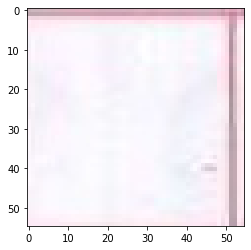

In [12]:
plt.imshow(img)

In [70]:
imgs = []
bad_images = []

imgs = [plt.imread(fname)[..., :3] for fname in images_list[10000:10500] ]

# Crop every image to a square
imgs_or = [utils.imcrop_tosquare(img_i) for img_i in imgs]

imgs_p = [resize(remove_color_and_add_filter(img_i), (100, 100,3)) for img_i in imgs_or]


# Finally make our list of 3-D images a 4-D array with the first dimension the number of images:
#
imgs_p = np.array(imgs_p[:]).astype(np.float32)




In [28]:
def plot_grid(img):
    # Plot the resulting dataset:
    # Make sure you "run" this cell after you create your `imgs` variable as a 4-D array!
    # Make sure we have a 100 x 100 x 100 x 3 dimension array
    #assert(imgs.shape == (100, 100, 100, 3))
    imgs_custom = img / 255.0
    plt.figure(figsize=(15, 15))
    plt.imshow(utils.montage(imgs_custom) )
  

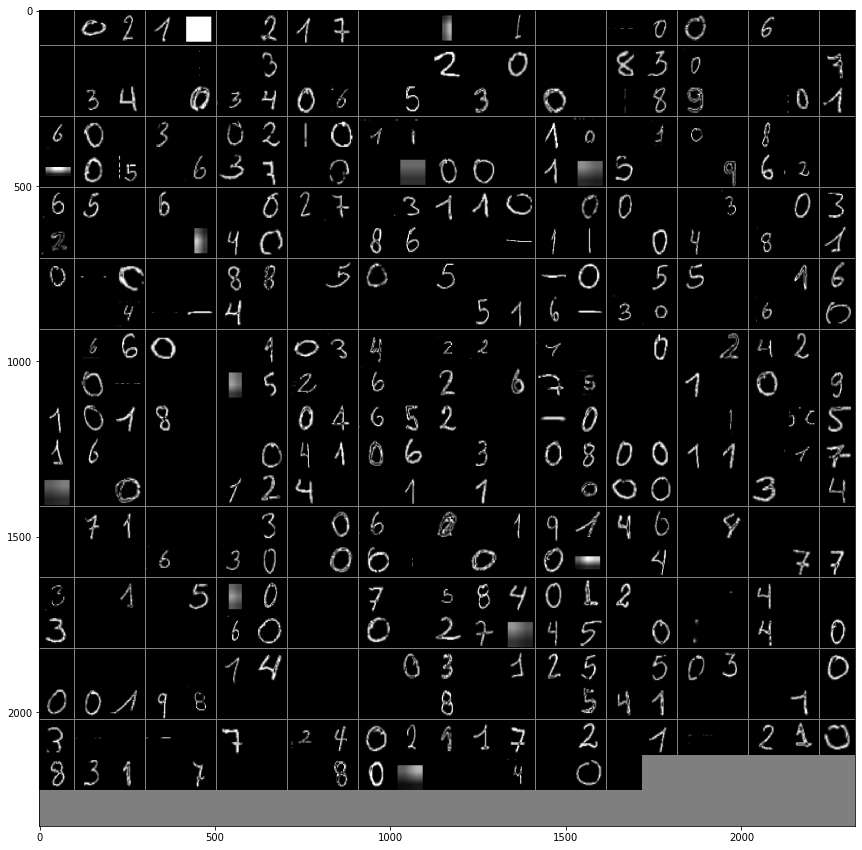

In [29]:
plot_grid(imgs_p)

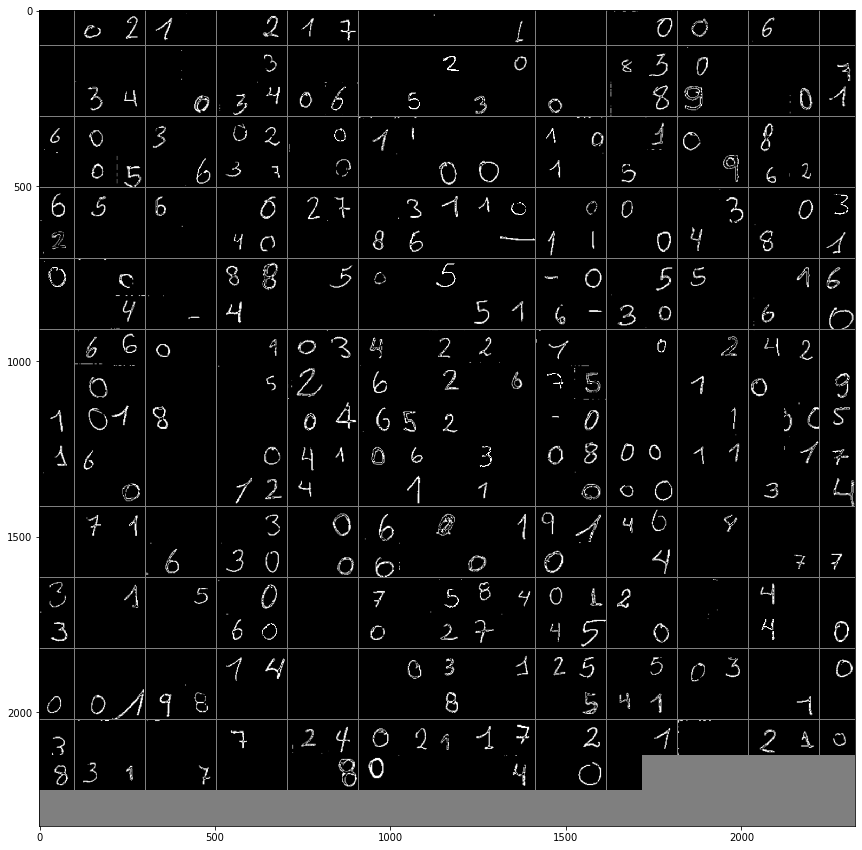

In [33]:
plot_grid(imgs_p)

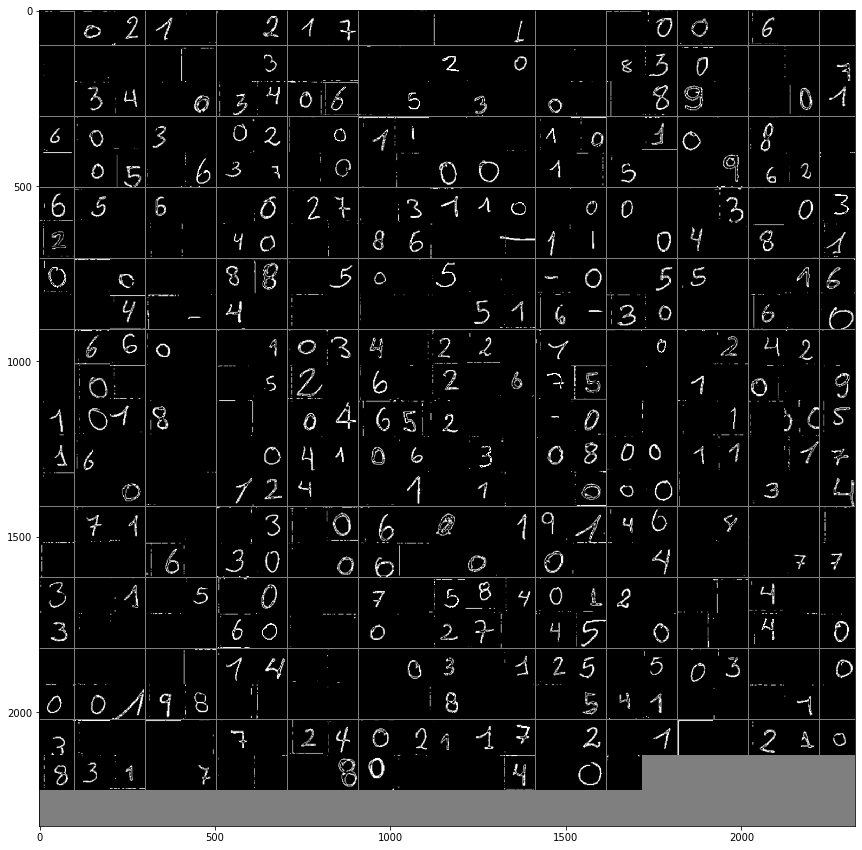

In [36]:
plot_grid(imgs_p)

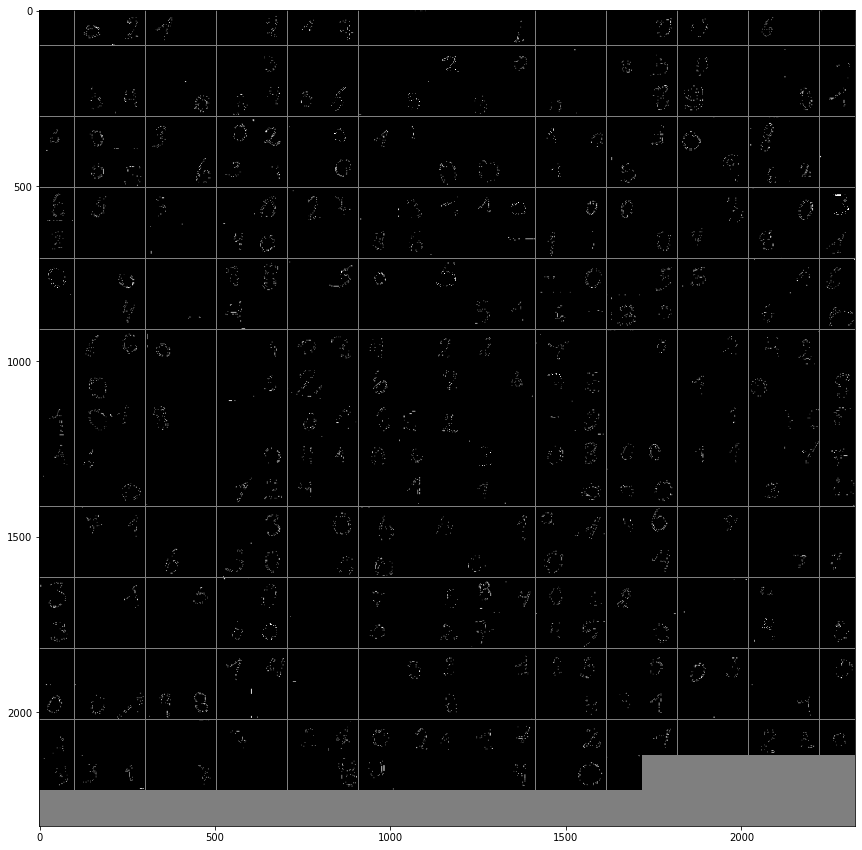

In [39]:
plot_grid(imgs_p)

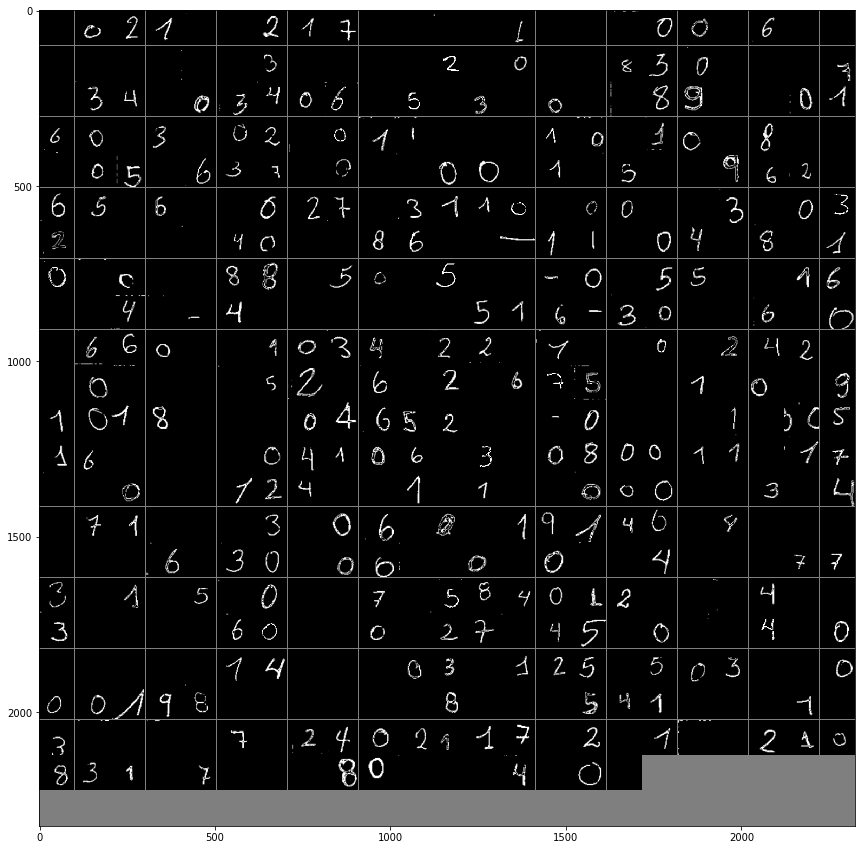

In [71]:
plot_grid(imgs_p)

In [28]:
path_1 = "/home/actas/*.jpg"
actas_list = glob.glob(path_1)
print(len(actas_list))

33068


In [35]:
!pip install opencv-python

  Using cached https://files.pythonhosted.org/packages/44/35/6db0fa2e644922533ddc2a3c41d1a86dabefce89d9db85ec31dcc69dc2e3/opencv_python-4.1.1.26-cp37-cp37m-manylinux1_x86_64.whl


In [209]:
import cv2
import glob
import os

#from model.test import MyModel
#rom model.restnet import MyModel
#from model.keras import MyModel
import argparse


class Partido:
    def __init__(self, name="", box_name=[], box_count=[]):
        self.name = name
        self.box_name = box_name
        self.box_count = box_count

class ValidosAndOthers:
    def __init__(self, name="", box_name=[], box_count=[]):
            self.name = name
            self.box_name = box_name
            self.box_count = box_count



class ImageHanlder:
    def __init__(self, cut_numbers=True, draw_results=False, all_boxes=True, draw_rects=False):
        self.font                   = cv2.FONT_HERSHEY_SIMPLEX
        self.fontScale              = 1
        self.fontColor              = (255,0,255)
        self.lineType               = 2

        # If all 24 boxes was discovered with the CV alog, map his ID to  his real-name
        self.name_map               = {"22": "CC", "14": "MAS"}

        self.cut_numbers=cut_numbers
        # Instantiate mnist model
        # self.model = MyModel()

        # Bounding rectangles placholder
        self.outputs = []

        # For handle the data 
        self.data_handler = []

        # Placholder for the partidos.
        self.partidos_todos = []
        self.partidos = []
        # If draw results
        self.draw_results = draw_results

        # If you only want to filter CC and MAS
        self.all_boxes = all_boxes
        
        # Expected position of partidos in 1088, 872 Resolution image
        # in the acta region.

        # CC Name box
        # P1 : 14,40
        # P2 : 520,90
        
        # Region containing the information about the Mesas to count
        self.P1 = (90*4, 98*4)
        self.P2 = (272*4, 218*4)
        
        
        self.draw_rects = draw_rects
        
        partidos_d = [24, 22, 20, 18, 16, 14, 12, 10, 8, 6]
        partidos = [23, 21, 19, 17, 15, 13, 11, 9, 7]

        otros_d = [4, 2, 6]
        otros = [5, 3, 1]

        self.partidos_todos = partidos + partidos_d

        self.otros_todos = otros + otros_d

        self.ids = partidos + partidos_d   + otros + otros_d
        
    def combine_lists(self):
          # combine all the info
        #self.partidos_todos = self.partidos.extend(self.partidos_d)
        self.todos_los_fields = self.partidos + self.partidos_d + self.otros + self.otros_d

        print(len(self.todos_los_fields))

    def write_row_debug_log(self, file_name, path_img, label):
        """
        Write log
        """
        base_path = "./test/results/"
        os.makedirs(base_path, exist_ok=True)

        path = f"{base_path}/{file_name}.txt"

        with open(path,"a+") as f:
            f.write(f"{path_img},{label} \n")


    def write_row_results_log(self, file_name, image_name, counts, id):
        """
        Write the last results
        """
        base_path = "results/"
        os.makedirs(base_path, exist_ok=True)
        path = f"{base_path}/{file_name}.txt"

        with open(path,"a+") as f:
            f.write(f"{image_name},{counts},{id} \n")


    def norm_image(self, image):
        """
        Norm image to constant shape
        """
        img = cv2.resize(image, (2500, 1600))
        return img

    def cut_image(self, image, p1, p2):
        """
        Crop any imagen given P1 and P2
        """
        x = p1[0]
        y = p1[1]

        w = p2[0]
        h = p2[1]

        crop_img = image[y:y+h, x:x+w]
        return crop_img


    def scale_image(self, image):
        """
        Scale Down any image by a factor of 4
        """
        h,w,c=image.shape

        img_r = cv2.resize(image, (int(w/4), int(h/4)))
        
        # img = cv2.imshow('res2', img_r)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()

    def find_contour_base(self, image, kernel):

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  
        
        #--- performing Otsu threshold ---
        ret,thresh1 = cv2.threshold(gray, 0, 255, 
                                    cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV)
        #--- choosing the right kernel
        #--- kernel size of 3 rows (to join dots above letters 'i' and 'j')
        #--- and 10 columns to join neighboring letters in words and neighboring words
        rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel)
        dilation = cv2.dilate(thresh1, rect_kernel, iterations = 1)
        #---Finding contours ---
        contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        im2 = image.copy()

        return im2, contours

    def find_contour(self, image, image_path):
        #(30, 2) for letters
        im2, contours = self.find_contour_base(image, (7,2))

        boxes = []
        outputs =[]

        # Iterate over all contours
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            p1 = (x, y)
            p2 = (x + w, y + h)

            deltax = p2[0]-p1[0]
            deltay = p2[1]-p1[1]

            if (200<=(deltax)<=360) and (30<=(deltay)<=70):
                # print(deltax)
                # print(deltay)
                p1 = (p1[0], p1[1])
                p2 = (p2[0] + 210*0, p2[1])

                boxes.append([p1,p2])
                
                if (self.draw_rects):
                    cv2.rectangle(im2, p1, p2, (0, 255, 0), 2)
        
        size = len(boxes)
        print(f"TOTAL BOXES {size}")
        
        # If all the rectanguler boxes was found.
        if size == 24:
            # print("size",size)

            # Iterate over the rectangular boxes
            for i, b in enumerate(boxes):
                
                partido_id = str(i+1)
                
                outputs.append({i+1: b})

                if self.cut_numbers:
                    cv2.putText(im2, partido_id, tuple(b[0]), self.font, 
                                                    self.fontScale,
                                                    self.fontColor,
                                                    self.lineType)
        else:
            """
            If detection is < 24 log this file
            """
            file_name = "detect_boxes_error_log"
            self.write_row_debug_log(file_name, image_path, size)

        return im2, outputs

    def obtain_two_partidos_region(self):
        outputs = [{
            "MAS" : (self.p1_mas,self.p2_mas),
            "CC" : (self.p1_cc, self.p2_cc)
        }]

        return outputs


    def find_contours_leters(self, image):

        im_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        im_gray = cv2.GaussianBlur(im_gray, (5, 5), 0)

        # Threshold the image
        ret, im_th = cv2.threshold(im_gray, 0, 155, cv2.THRESH_BINARY_INV)

        # Find contours in the image
        ctrs, hier = cv2.findContours(im_th.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Get rectangles contains each contour
        rects = [cv2.boundingRect(ctr) for ctr in ctrs]

        return rects
    
    def calculate_area(self, p1,p2):
        w = p2[0] - p1[0]
        h = p2[1] - p1[1]
        area = w*h
        print(area)
        return area
    
    def draw_rectangle_numpy(self, img, p1,p2):
        img = cv2.rectangle(img, p1, p2, (0, 255, 0), 2)
        return img
    def main(self, images_list):
        

        for i_path in images_list:
            try:
                # Try to open the image
                #i = "actas/mesas/200081.jpg"
                img     =   cv2.imread(i_path)

                img_r   =   self.norm_image(img)

                # extract only the votation box
                c_image =   self.cut_image(img_r, P1, P2)

                # Obtain the full filename
                filename = i_path.split("/")[-1]

                # Obtain only the name without extension 
                filename_two = filename.split(".")[0]

                print(filename)
                
                # Find the contours box rectangle for each partido 
                cont_img, self.outputs = self.find_contour(c_image, i_path)
                
                for o in self.outputs:

                        # Iterate over the rectangular boxes
                        for k,v in o.items():
                            #print(f"WORKING ON {k}")
                            partido_key_id = k  
                            
                            p1, p2 = v

                            if k in self.partidos_todos:
                                # Mueva Position tira 
                                n_p1 = (p1[0] + 340, p1[1])
                                n_p2 = (p2[0] + 180, p2[1])

                            if k in self.otros_todos:

                                # Mueva Position tira 
                                n_p1 = (p1[0] + 310, p1[1])
                                n_p2 = (p2[0] + 215, p2[1])

                            self.draw_rectangle_numpy(cont_img, n_p1, n_p2 )
                            
                            # Letters as image |X|X|X|
                            numbers_cout = self.cut_image(partidos_cut, p1_n, p2_n)

                            # Find again the letters with the contour detector:
                            l_h, l_w, _ = numbers_cout.shape

                            # Attempt to cut each letter
                            votes = []
                            for i in range(0,3):

                                # Sliding x-window
                                x0 = i*55 + 5
                                x1 = (i+1)*55 + 5

                                # New Points
                                p1_l = (x0, 0)
                                p2_l = (x1, l_h)

                                if (self.draw_rects):
                                    cv2.rectangle(numbers_cout, p1_l, p2_l, (0, 255, 0), 2)

                                # Adjust each letter to his aprox box
                                if (i == 0):
                                    letter = self.cut_image(numbers_cout, p1_l, p2_l)
                                elif (i == 1):
                                    p1_l_n = (p1_l[0]+5, p1_l[1])
                                    p2_l_n = (p2_l[0]-60, p2_l[1])
                                    letter = self.cut_image(numbers_cout, p1_l, p2_l_n)
                                else:
                                    p2_l_n = (p2_l[0]-120, p2_l[1])
                                    letter = self.cut_image(numbers_cout, p1_l, p2_l_n)

                                # Load MNIST PyTorch Model
                                # Convert to grayscale and apply Gaussian filtering

                                # l_contours = self.find_contours_leters(letter)
                                # for rect in l_contours:

                                # prediction = self.model.main_prediction(letter)
                                #print(f"THIS PREDICTION for {partido_key_id}: {prediction}")
                                predictions = 0.0
                                votes.append(prediction)
                                # cv2.putText(im2,partido_id, tuple(b[0]), self.font, 
                                #                                 self.fontScale,
                                #                                 self.fontColor,
                                #                                 self.lineType)

                                if self.cut_numbers:
                                    # Path where save the digit numbers
                                    path = "./test/actas/cuts/partidos/numbers/i_letter/"
                                    os.makedirs(path, exist_ok=True)
                                    full_path = f"{path}-{k}-{i}-{filename}"
                                    # Save
                                    print(f"Saving letter to... {full_path}")
                                    cv2.imwrite(full_path, letter)

                            self.data_handler.append({partido_key_id: [votes, v]})       
                            #  save tiras
                            cv2.imwrite(f"./test/actas/cuts/partidos/numbers/{filename_two}-{k}-.jpg", numbers_cout)

                        _file_name_log = "results_log"

                        for p in self.data_handler:
                            for k,v in p.items():
                                partido_id_name = k
                                my_predictions, points = v

                                # join number predictions
                                my_vote = ""
                                for p in my_predictions:
                                    if p == "10":
                                        p = ""
                                    my_vote = my_vote + str(p)
                                p1, p2 = points

                                p_text = (p2[0]-110, p2[1] +20)
                                cv2.putText(cont_img, my_vote, tuple(p_text), self.font, 
                                                                self.fontScale,
                                                                self.fontColor,
                                                                self.lineType)

                                self.write_row_results_log(_file_name_log, 
                                                                filename,
                                                                my_vote,
                                                                partido_id_name)

                        self.data_handler=[]

                        # Write the acta with the number of results drawed on it.
                        if self.draw_results:

                            base_path = "./test/actas/cuts/"

                            os.makedirs(base_path, exist_ok=True)
                            path = f"{base_path}/{filename}"

                            cv2.imwrite(path, cont_img)
            except Exception as e:
                _filename_error = "errorInOpenFile"
                self.write_row_debug_log(_filename_error, filename, e)
                print(e)
            break
            # except Exception as e:
            #     print(e)




In [38]:
images_list=actas_list[:5]

In [39]:
%ls 

libs/  montage.png  Pixel_wise_ana.ipynb  test/


In [30]:
%mkdir test

In [210]:
draw_results=True
all_boxes=True
image_handler = ImageHanlder(cut_numbers=images_list, # For custom mnist dataset creation
                            draw_results=draw_results,  # Draw the actas with the result drawed on it
                            all_boxes=all_boxes,     # Just find CC and MAS or all
                             draw_rects=True
                            )


In [205]:
print(image_handler.partidos_todos)
print(image_handler.otros_todos)

[22, 20, 18, 16, 14, 12, 10, 8, 6, 23, 21, 19, 17, 15, 13, 11, 9, 7]
[5, 3, 1, 4, 2, 6]


In [239]:
print(f"TOTAL {len(images_list)}")
images_q = []

for i in images_list:
    check_images(i)

TOTAL 5
720391.jpg
TOTAL BOXES 24
721931.jpg
TOTAL BOXES 24
361011.jpg
TOTAL BOXES 24
OpenCV(4.1.1) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

267671.jpg
TOTAL BOXES 24


96


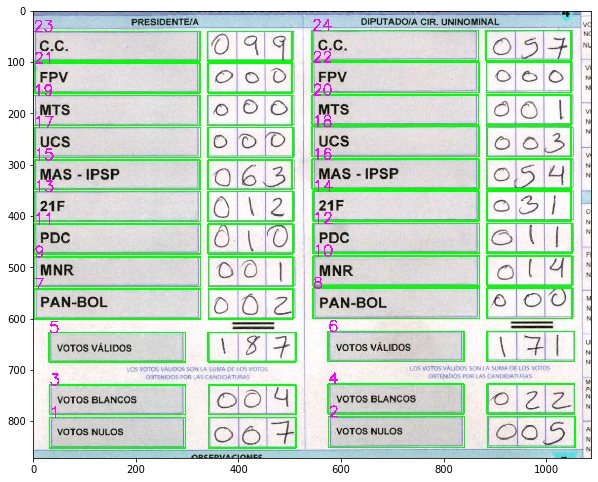

In [240]:
print(len(images_q))
plt.figure(figsize=(10,10))
plt.imshow(images_q[0])

In [ ]:
image_handler.main(
    images_list
)

# TOTAL ACTAS

In [6]:
path = "/home/actas/"

In [7]:
actas = glob.glob(path + "*.jpg")

print(f"TOTAL ACTAS TO PROCESS: {len(actas)}")

TOTAL ACTAS TO PROCESS: 33068


# Load actas...

In [215]:
path = "../actas-de-mesa/actas/cuts/"

In [216]:
actas = glob.glob(path + "*.jpg")

In [217]:
print(f" TOTAL processed actas :{len(actas)}")


 TOTAL processed actas :334


In [11]:
# Aux functinos

P1 = (90*4, 98*4)
P2 = (272*4, 218*4)

font                   = cv2.FONT_HERSHEY_SIMPLEX
fontScale              = 1
fontColor              = (255,0,255)
lineType               = 2


def find_contour_base(image, kernel):

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  

    #--- performing Otsu threshold ---
    ret,thresh1 = cv2.threshold(gray, 0, 255, 
                                cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV)
    #--- choosing the right kernel
    #--- kernel size of 3 rows (to join dots above letters 'i' and 'j')
    #--- and 10 columns to join neighboring letters in words and neighboring words
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel)
    dilation = cv2.dilate(thresh1, rect_kernel, iterations = 1)
    #---Finding contours ---
    contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    im2 = image.copy()

    return im2, contours
        
def find_contour(image, image_path=""):
    
    #(30, 2) for letters
    im2, contours = find_contour_base(image, (7,2))

    boxes = []
    outputs =[]

    # Iterate over all contours
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        p1 = (x, y)
        p2 = (x + w, y + h)

        deltax = p2[0]-p1[0]
        deltay = p2[1]-p1[1]

        if (200<=(deltax)<=360) and (30<=(deltay)<=70):
            # print(deltax)
            # print(deltay)
            p1 = (p1[0], p1[1])
            p2 = (p2[0] + 210*0, p2[1])

            boxes.append([p1,p2])

            cv2.rectangle(im2, p1, p2, (0, 255, 0), 2)

    size = len(boxes)
    print(f"TOTAL BOXES {size}")

    # If all the rectanguler boxes was found.
    if size == 24:
        # print("size",size)

        # Iterate over the rectangular boxes
        for i, b in enumerate(boxes):

            partido_id = str(i+1)

            outputs.append({i+1: b})


            cv2.putText(im2, partido_id, tuple(b[0]), 
                                            font, 
                                            fontScale,
                                            fontColor,
                                            lineType)
    else:
        """
        If detection is < 24 log this file
        """
        file_name = "detect_boxes_error_log"
        print(f"ERROR BOxes {file_name} - {size}")
    return im2, outputs


def norm_image(image):
    """
    Norm image to constant shape
    """
    img = cv2.resize(image, (2500, 1600))
    return img

def cut_image(image, p1, p2, simple=False):
    """
    Crop any imagen given P1 and P2
    """
    x = p1[0]
    y = p1[1]

    w = p2[0]
    h = p2[1]

    if simple:
        crop_img = image[y:h, x:w]
    crop_img = image[y:y+h, x:x+w]
    return crop_img

In [12]:
def show_image(file_name, full=False):
    
    img = cv2.imread(file_name)
    
    if full:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        img_r   =  norm_image(img)
        # extract only the votation box
        c_image =   cut_image(img_r, P1, P2)

        cont_img,  outputs = find_contour(c_image)

        plt.figure(figsize=(10,10))
        plt.imshow(cont_img)
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(10,10))
        plt.imshow(img)

In [ ]:
# Show some random processed acta

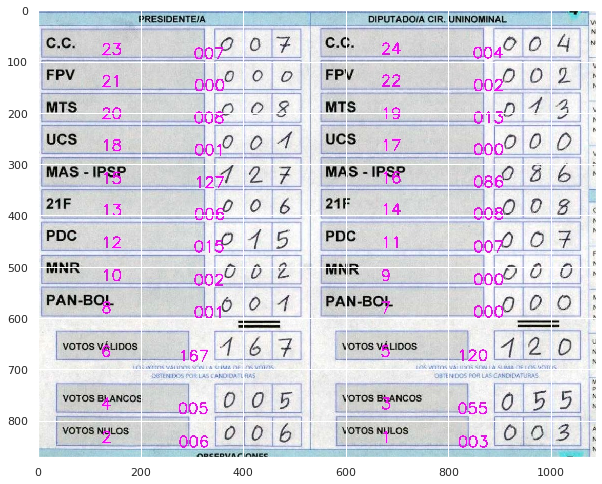

In [218]:
show_image(actas[3])

## Load debug results

In [14]:
path_csv = "../actas-de-mesa/results/"

In [15]:
csv_files = glob.glob(path_csv + "*.txt")

In [16]:
len(csv_files)

3

In [17]:
# Debug data
debug_data = csv_files[2]
print(debug_data)

../actas-de-mesa/results/detect_boxes_error_log.txt


In [18]:
df_debug = pd.read_csv(debug_data, names = ["file", "boxes"])
df_debug.head()

,file,boxes
0,/home/actas/339251.jpg,12
1,/home/actas/347511.jpg,12
2,/home/actas/260401.jpg,0
3,/home/actas/243221.jpg,0
4,/home/actas/19571.jpg,8


In [19]:
u_actas_debug = np.unique(df_debug["file"])

print(f"TOTAL ACTAS DEBUG {len(u_actas_debug)}")

TOTAL ACTAS DEBUG 12990


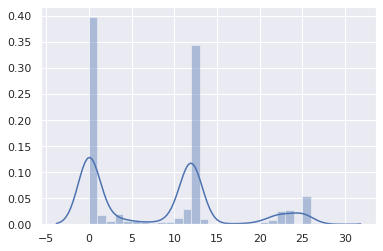

In [20]:
boxes_c = list(df_debug["boxes"])
sns.distplot(boxes_c);

In [21]:
uniques = np.unique(boxes_c)

In [22]:
counts = []
keys = uniques
values = []

for u in uniques:
    counts.append({u : boxes_c.count(u)})
    values.append( boxes_c.count(u))
    

In [23]:
counts

[{0: 5167},
 {1: 231},
 {2: 90},
 {3: 266},
 {4: 91},
 {5: 79},
 {6: 58},
 {7: 43},
 {8: 47},
 {9: 69},
 {10: 158},
 {11: 379},
 {12: 4482},
 {13: 136},
 {14: 17},
 {15: 10},
 {16: 8},
 {17: 17},
 {18: 16},
 {19: 18},
 {20: 51},
 {21: 114},
 {22: 339},
 {23: 356},
 {25: 704},
 {26: 40},
 {27: 3},
 {28: 1}]

In [ ]:
# Create separate dataframes for each one.


In [24]:
df_lists = []
for u in uniques:
    df_lists.append({u:[]})
    

print(df_lists)

[{0: []}, {1: []}, {2: []}, {3: []}, {4: []}, {5: []}, {6: []}, {7: []}, {8: []}, {9: []}, {10: []}, {11: []}, {12: []}, {13: []}, {14: []}, {15: []}, {16: []}, {17: []}, {18: []}, {19: []}, {20: []}, {21: []}, {22: []}, {23: []}, {25: []}, {26: []}, {27: []}, {28: []}]


In [25]:
for _df in df_lists:
    for k, v in _df.items():
        _aux_df = df_debug[df_debug["boxes"] == k]
        v.append(_aux_df)



In [26]:
def query_df(key):
    return df_lists[key][key][0]



In [27]:
df_0 = query_df(0)

In [28]:
df_0.head()

,file,boxes
2,/home/actas/260401.jpg,0
3,/home/actas/243221.jpg,0
6,/home/actas/212361.jpg,0
7,/home/actas/22411.jpg,0
8,/home/actas/255111.jpg,0


In [29]:
df_0.shape

(5167, 2)

In [30]:
r_number = random.randint(0, df_debug.shape[0])
img_name = df_debug["file"][r_number -1]
value =  df_debug["boxes"][r_number - 1]
print(img_name, value )


/home/actas/308481.jpg 12


In [139]:
acta_n = "/home/actas/511691.jpg"

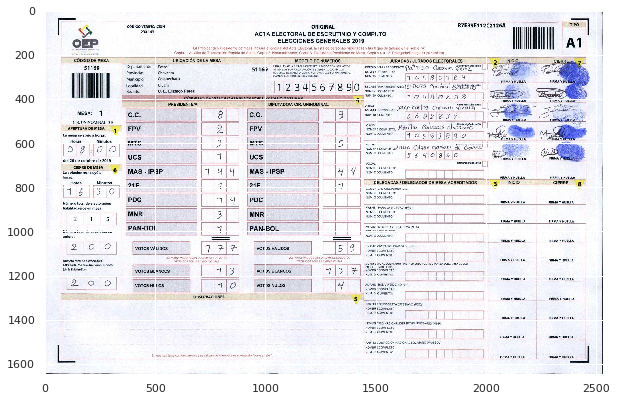

In [141]:
show_image(acta_n, full=False)

# RESULTS DATAFRAME

In [32]:
resutls_data = csv_files[1]

In [33]:
df = pd.read_csv(resutls_data, names=["id", "counts", "partidoid"])
df.head()

,id,counts,partidoid
0,720391.jpg,7.0,1
1,720391.jpg,5.0,2
2,720391.jpg,4.0,3
3,720391.jpg,22.0,4
4,720391.jpg,187.0,5


In [34]:
u_actas = np.unique(df["id"])
print(len(u_actas))

19562


In [35]:
df.shape

(468343, 3)

In [ ]:
# mas 15
# CC 23

In [ ]:
# CC

In [36]:
df_cc = df[df["partidoid"] == 23]
t_count = df_cc["counts"].sum()
print(t_count)

1352848.0


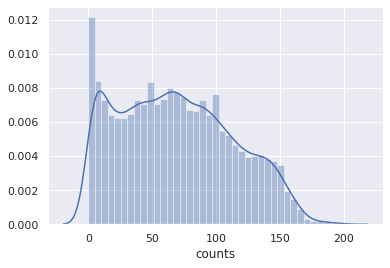

In [37]:
df_cc = df_cc.dropna()

df_cc_f = df_cc[df_cc["counts"]< 200]

sns.distplot(df_cc_f["counts"]);

In [ ]:
# MAS

In [38]:
df_mas = df[df["partidoid"] == 15]
t_count_mas = df_mas["counts"].sum()
print(t_count_mas)

1454429.0


In [178]:
df_mas = df_mas.dropna()
df_mas_f = df_mas[df_mas["counts"] < 270]

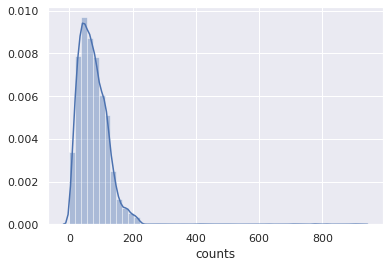

In [69]:
sns.distplot(df_mas["counts"]);

In [43]:
my_list = df_mas[df["counts"] > 200]

/home/stanley/anaconda3/envs/cv-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [44]:
len(my_list)


195

In [45]:
my_list["counts"].sum()

56235.0

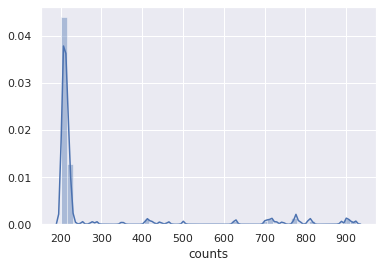

In [46]:
sns.distplot(my_list["counts"]);

# COMPARATIONS

In [ ]:
# Cross validate with official xls

In [73]:
!wget https://www.dropbox.com/s/f9i1mx7j4h7e0eu/acta.2019.10.25.21.09.30%281%29.xlsx

--2019-11-04 17:26:45--  https://www.dropbox.com/s/f9i1mx7j4h7e0eu/acta.2019.10.25.21.09.30%281%29.xlsx
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.1, 2620:100:601d:1::a27d:501
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/f9i1mx7j4h7e0eu/acta.2019.10.25.21.09.30%281%29.xlsx [following]
--2019-11-04 17:26:46--  https://www.dropbox.com/s/raw/f9i1mx7j4h7e0eu/acta.2019.10.25.21.09.30%281%29.xlsx
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc11237c6598a1cf396987077398.dl.dropboxusercontent.com/cd/0/inline/ArxbUwC_CkVCGTomMlFJC9JtXJQbNY9zfnX4bBbUd32WdPOnFipHnFuvlic4MWmlKH1PSKKUOuVfJqCR4MFPvvn1XgL2XNmyx6Pe71ej5g8c6Uh3JPV-gFWYpGMIL4m6GqU/file# [following]
--2019-11-04 17:26:46--  https://uc11237c6598a1cf396987077398.dl.dropboxusercontent.com/cd/0/inline/ArxbUwC_CkVCGTomMlFJC9JtXJQbNY9zfnX4bBbUd3

In [213]:
#path = "acta.2019.10.25.10.13.40.xlsx"
#path = "acta.2019.10.22.22.29.53.xlsx"

path = "acta.2019.10.25.21.09.30(1).xlsx"

In [214]:
df_x = pd.read_excel(path)

In [49]:
df_x.shape

(68140, 26)

In [50]:
df_x.columns

Index(['País', 'Número departamento', 'Departamento', 'Provincia',
       'Número municipio', 'Municipio', 'Circunscripción', 'Localidad',
       'Recinto', 'Número Mesa', 'Código Mesa', 'Elección', 'Inscritos', 'CC',
       'FPV', 'MTS', 'UCS', 'MAS - IPSP', '21F', 'PDC', 'MNR', 'PAN-BOL',
       'Votos Válidos', 'Blancos', 'Nulos', 'Estado acta'],
      dtype='object')

In [51]:
df_x.head()

,País,Número departamento,Departamento,Provincia,Número municipio,Municipio,Circunscripción,Localidad,Recinto,Número Mesa,...,UCS,MAS - IPSP,21F,PDC,MNR,PAN-BOL,Votos Válidos,Blancos,Nulos,Estado acta
0,Argentina,10,Buenos Aires,Quilmes,1,Quilmes,NaN,Ezpeleta,Esc Primaria Nro 52 Gral. Bartolome Mitre.,1455,...,0,118,0,3,1,2,126,1,1,Computada
1,Argentina,10,Buenos Aires,Quilmes,1,Quilmes,NaN,Ezpeleta,Esc Primaria Nro 52 Gral. Bartolome Mitre.,1456,...,0,110,0,5,1,1,125,1,6,Computada
2,Argentina,10,Buenos Aires,Quilmes,1,Quilmes,NaN,Ezpeleta,Esc Primaria Nro 52 Gral. Bartolome Mitre.,1457,...,1,120,2,3,0,0,131,1,5,Computada
3,Argentina,10,Buenos Aires,Quilmes,1,Quilmes,NaN,Ezpeleta,Esc Primaria Nro 52 Gral. Bartolome Mitre.,1458,...,1,124,0,2,0,2,139,2,2,Computada
4,Argentina,10,Buenos Aires,Quilmes,1,Quilmes,NaN,Ezpeleta,Esc Primaria Nro 52 Gral. Bartolome Mitre.,1459,...,0,122,0,6,0,0,136,1,2,Computada


In [53]:
# delete diputados
df_x = df_x[df_x["Elección"] == "Presidente y Vicepresidente"]
df_x.head()

,País,Número departamento,Departamento,Provincia,Número municipio,Municipio,Circunscripción,Localidad,Recinto,Número Mesa,...,UCS,MAS - IPSP,21F,PDC,MNR,PAN-BOL,Votos Válidos,Blancos,Nulos,Estado acta
0,Argentina,10,Buenos Aires,Quilmes,1,Quilmes,NaN,Ezpeleta,Esc Primaria Nro 52 Gral. Bartolome Mitre.,1455,...,0,118,0,3,1,2,126,1,1,Computada
1,Argentina,10,Buenos Aires,Quilmes,1,Quilmes,NaN,Ezpeleta,Esc Primaria Nro 52 Gral. Bartolome Mitre.,1456,...,0,110,0,5,1,1,125,1,6,Computada
2,Argentina,10,Buenos Aires,Quilmes,1,Quilmes,NaN,Ezpeleta,Esc Primaria Nro 52 Gral. Bartolome Mitre.,1457,...,1,120,2,3,0,0,131,1,5,Computada
3,Argentina,10,Buenos Aires,Quilmes,1,Quilmes,NaN,Ezpeleta,Esc Primaria Nro 52 Gral. Bartolome Mitre.,1458,...,1,124,0,2,0,2,139,2,2,Computada
4,Argentina,10,Buenos Aires,Quilmes,1,Quilmes,NaN,Ezpeleta,Esc Primaria Nro 52 Gral. Bartolome Mitre.,1459,...,0,122,0,6,0,0,136,1,2,Computada


In [82]:
# delete diputados
#df_x = df_x[df_x['"Circunscripción"'].isnull()]
#df_x.head()

In [54]:
df_x.shape

(34555, 26)

# CC

In [124]:
df_cc.head()

,id,counts,partidoid,mesa
22,720391.jpg,99.0,23,72039
46,721931.jpg,108.0,23,72193
70,361011.jpg,12.0,23,36101
94,267671.jpg,11.0,23,26767
118,770831.jpg,106.0,23,77083


In [125]:
df_cc.shape

(19232, 4)

In [55]:
# Extract mesa id column 
def label_race(row):
    name = row["id"]
    return name.split(".")[0][:-1]

df_cc["mesa"] = df_cc.apply (lambda row: label_race(row), axis=1)
df_cc.head()

,id,counts,partidoid,mesa
22,720391.jpg,99.0,23,72039
46,721931.jpg,108.0,23,72193
70,361011.jpg,12.0,23,36101
94,267671.jpg,11.0,23,26767
118,770831.jpg,106.0,23,77083


In [ ]:
# Filther only the mesas that are in CC

In [63]:
uniques_cc = np.unique(list(df_cc["mesa"]))
uniques_excel = list(np.unique(df_x["Número Mesa"]))

print(len(uniques_cc))
print(len(uniques_excel))


19232
34555


In [60]:
from bisect import bisect_left
class Search:
    def __init__(self):
        pass
    
    def my_search(self, alist, item):
        'Locate the leftmost value exactly equal to item'
        i = bisect_left(alist, item)
        if i != len(alist) and alist[i] == item:
            return True
        else:
            return False

        raise ValueError
        
    def __call__(self, search_in = [], query_search = [] ):
        """
        Search if element in uniques_partido is in uniques_excel, if so, append
        """
        not_in = []
        
        alist = search_in
        
        alist.sort() # bisect only works on sorted lists

        for u in query_search:
            x = int(u)
            if self.my_search(list(alist), x):
                pass
            else:
                not_in.append(u)
                
        return not_in
    
search = Search()


In [64]:
not_in = search(search_in = uniques_excel, 
                query_search = uniques_cc)



In [65]:
print(len(not_in))

0


In [132]:
df_x.loc[df_x['Número Mesa'] == 26889]

,País,Número departamento,Departamento,Provincia,Número municipio,Municipio,Circunscripción,Localidad,Recinto,Número Mesa,...,UCS,MAS - IPSP,21F,PDC,MNR,PAN-BOL,Votos Válidos,Blancos,Nulos,Estado acta
19059,Bolivia,2,La Paz,Larecaja,2,Guanay,NaN,Carura,U.E. Carura B,26889,...,0,75,3,20,1,0,116,6,4,Computada


In [133]:
mesas_c = [int(m) for m in uniques_cc ]

df_f  = df_x[df_x["Número Mesa"].isin(mesas_c) ]

df_f.head()

,País,Número departamento,Departamento,Provincia,Número municipio,Municipio,Circunscripción,Localidad,Recinto,Número Mesa,...,UCS,MAS - IPSP,21F,PDC,MNR,PAN-BOL,Votos Válidos,Blancos,Nulos,Estado acta
261,Bolivia,1,Chuquisaca,Oropeza,1,Sucre,NaN,Arabate,Escuela Arabate,10001,...,0,79,1,0,0,0,82,6,11,Computada
263,Bolivia,1,Chuquisaca,Oropeza,1,Sucre,NaN,Chaunaca,Escuela Seccional De Chaunaca,10002,...,2,135,3,11,1,1,171,6,12,Computada
267,Bolivia,1,Chuquisaca,Oropeza,1,Sucre,NaN,Chuqui Chuqui,Unidad Educativa Chuqui Chuqui,10004,...,2,118,3,11,2,0,168,11,13,Computada
269,Bolivia,1,Chuquisaca,Oropeza,1,Sucre,NaN,Chuqui Chuqui,Unidad Educativa Chuqui Chuqui,10005,...,1,118,6,15,0,0,172,13,5,Computada
271,Bolivia,1,Chuquisaca,Oropeza,1,Sucre,NaN,Chuqui Chuqui,Unidad Educativa Chuqui Chuqui,10006,...,0,74,5,8,0,1,106,7,2,Computada


In [134]:
df_f.shape

(19232, 26)

## Filther the bad counts

Filther the counts

In [188]:
counts_cc = [int(c) for c in list(df_cc["counts"])]
counts_excel_cc = [int(c) for c in list(df_f["CC"])]

print(len(counts_cc))
print(len(counts_excel_cc))

19232
19499


In [189]:
not_in = search(search_in = counts_excel_cc, 
                query_search = counts_cc)

print(len(not_in))

79


In [190]:
not_in = np.unique(not_in)
print(len(not_in))

56


In [191]:
not_in[:10]

array([182, 183, 184, 186, 187, 188, 189, 191, 193, 195])

In [192]:
def check_flaw(flaw):
    """
    Search in predicted CC the count
    """
    return df_cc.loc[df_cc["counts"] == flaw]

In [193]:
f = float(not_in[55])
print(f)
flaw_df = check_flaw(f)
flaw_df.head()

964.0


,id,counts,partidoid,mesa
354714,721481.jpg,964.0,23,72148


In [280]:
#df_x.loc[df_x['Número Mesa'] == 75203]

In [194]:
m = df_x.loc[df_x['Número Mesa'] == 72148]

print(m["CC"])
print(m["MAS - IPSP"])

48977    164
Name: CC, dtype: int64
48977    12
Name: MAS - IPSP, dtype: int64


###### ALgo

90155 , 188 por 088
40273 , 188 por 088
74127 , 188 por 138
74264, 188 por 138
23400, 188 por 038
70306, 191 por 121
80578, 191 por 91
26229, 661.0 por 22
705001, 242. por 141
81175, 534.0 por 34
90272, 817 por 17
75203, 950, 92
21253, 766, 166
80578, 191 por 91
50129, 306 por 106
80618, 198, 098
76732, 198, 128
90123, 189, 99
80470, 189, 119
90153, 189, 89
74602, 182, 152
90060, 182, 082
90036, 182, 088
77040, 182, 122
21126, 182, 32
90155, 188, 088
40273, 188, 88
90364, 184, 37
90085, 184, 61
41539, 186, 8
28195, 186, 8
90140, 187, 087
40194, 193, 93
70575, 195, 145
75071, 196, 126
80148, 197, 87
80618, 198, 98
76732, 198. 128
76064, 204, 104
21129, 216, 27
60568, 228, 128

70500, 242, 142
10155, 244, 144

28229, 251, 25
71282, 254, 154

50129, 306, 106
81119, 344, 044

80643, 349, 049
40492, 411, 111

72075, 413, 113

71028, 424, 122

90022, 484, 84

710141, 530, 130

70515, 541, 154

73356, 542, 042

80322, 603, 103

40148, 669, 119

26229, 661, 20
75188, 700, 100	

41149, 701,30
81079, 702, 002
70134, 712, 112
22354, 736, 136
70131, 748, 148
21253, 766,166
90272, 817, 17
78093, 822, 022
70370, 825, 125
71892, 834, 134

73443, 841, 95
75032, 880, 60
74836, 883, 83
77494, 888, 115
90037, 888, 089
70153, 929 , 129
75203, 950, 92
72148, 964, 164

In [ ]:
CALCADO
75093

In [ ]:
# FLAWs
40134
74682
22334
61285

## Seconds TEst

In [195]:
# Dataframe format for cc

df_f_cc = df_f[df_f["CC"].isin(counts_cc)]
df_f_cc.head()

,País,Número departamento,Departamento,Provincia,Número municipio,Municipio,Circunscripción,Localidad,Recinto,Número Mesa,...,UCS,MAS - IPSP,21F,PDC,MNR,PAN-BOL,Votos Válidos,Blancos,Nulos,Estado acta
261,Bolivia,1,Chuquisaca,Oropeza,1,Sucre,NaN,Arabate,Escuela Arabate,10001,...,0,79,1,0,0,0,82,6,11,Computada
263,Bolivia,1,Chuquisaca,Oropeza,1,Sucre,NaN,Chaunaca,Escuela Seccional De Chaunaca,10002,...,2,135,3,11,1,1,171,6,12,Computada
267,Bolivia,1,Chuquisaca,Oropeza,1,Sucre,NaN,Chuqui Chuqui,Unidad Educativa Chuqui Chuqui,10004,...,2,118,3,11,2,0,168,11,13,Computada
269,Bolivia,1,Chuquisaca,Oropeza,1,Sucre,NaN,Chuqui Chuqui,Unidad Educativa Chuqui Chuqui,10005,...,1,118,6,15,0,0,172,13,5,Computada
271,Bolivia,1,Chuquisaca,Oropeza,1,Sucre,NaN,Chuqui Chuqui,Unidad Educativa Chuqui Chuqui,10006,...,0,74,5,8,0,1,106,7,2,Computada


In [137]:
df_f_cc.shape

(19232, 26)

OFFICIAL
sume: 1380748
votes count mean: 70.81122108826094
votes count std: 44.722172655786714


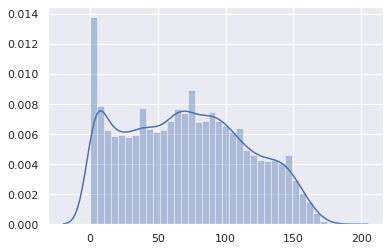

In [201]:
cc_counts = list(df_f_cc["CC"])

print("OFFICIAL")
print(f"sume: {np.sum(cc_counts)}")
print(f"votes count mean: {np.mean(cc_counts)}")
print(f"votes count std: {np.std(cc_counts)}")

sns.distplot(cc_counts);

In [173]:
df_cc_f.head()

,id,counts,partidoid
22,720391.jpg,99.0,23
46,721931.jpg,108.0,23
70,361011.jpg,12.0,23
94,267671.jpg,11.0,23
118,770831.jpg,106.0,23


PREDICTED
sume: 1327081.0
votes count mean: 69.16202835105274
votes count std: 44.22635838735568


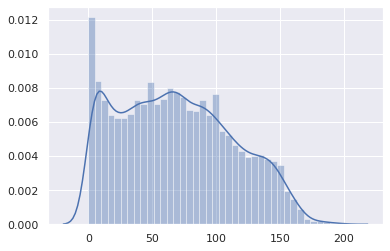

In [203]:
print("PREDICTED")

c = list(df_cc_f["counts"])
sume_cc = np.sum(df_cc_f["counts"])

print(f"sume: {sume_cc}")
print(f"votes count mean: {np.mean(c)}")
print(f"votes count std: {np.std(c)}")
sns.distplot(c);

# MAS

In [56]:
# Extract mesa id column 
def label_race(row):
    name = row["id"]
    return name.split(".")[0][:-1]

df_mas["mesa"] = df_mas.apply (lambda row: label_race(row), axis=1)
df_mas.head()

/home/stanley/anaconda3/envs/cv-env/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,counts,partidoid,mesa
14,720391.jpg,63.0,15,72039
38,721931.jpg,31.0,15,72193
62,361011.jpg,160.0,15,36101
86,267671.jpg,110.0,15,26767
110,770831.jpg,57.0,15,77083


In [62]:
uniques_mas = np.unique(list(df_mas["mesa"]))
uniques_excel = list(np.unique(df_x["Número Mesa"]))

print(len(uniques_mas))
print(len(uniques_excel))


not_in = search(search_in = uniques_excel, 
                query_search = uniques_mas)

print(len(not_in))

19499
34555
0


In [66]:
mesas_c = [int(m) for m in uniques_mas ]

df_f  = df_x[df_x["Número Mesa"].isin(mesas_c) ]

print(df_f.shape)

df_f.head()

(19499, 26)


,País,Número departamento,Departamento,Provincia,Número municipio,Municipio,Circunscripción,Localidad,Recinto,Número Mesa,...,UCS,MAS - IPSP,21F,PDC,MNR,PAN-BOL,Votos Válidos,Blancos,Nulos,Estado acta
261,Bolivia,1,Chuquisaca,Oropeza,1,Sucre,NaN,Arabate,Escuela Arabate,10001,...,0,79,1,0,0,0,82,6,11,Computada
263,Bolivia,1,Chuquisaca,Oropeza,1,Sucre,NaN,Chaunaca,Escuela Seccional De Chaunaca,10002,...,2,135,3,11,1,1,171,6,12,Computada
267,Bolivia,1,Chuquisaca,Oropeza,1,Sucre,NaN,Chuqui Chuqui,Unidad Educativa Chuqui Chuqui,10004,...,2,118,3,11,2,0,168,11,13,Computada
269,Bolivia,1,Chuquisaca,Oropeza,1,Sucre,NaN,Chuqui Chuqui,Unidad Educativa Chuqui Chuqui,10005,...,1,118,6,15,0,0,172,13,5,Computada
271,Bolivia,1,Chuquisaca,Oropeza,1,Sucre,NaN,Chuqui Chuqui,Unidad Educativa Chuqui Chuqui,10006,...,0,74,5,8,0,1,106,7,2,Computada


# Filthr the bad counts

In [70]:
counts_mas = [int(c) for c in list(df_mas["counts"])]
counts_excel_mas = [int(c) for c in list(df_f["MAS - IPSP"])]

print(len(counts_mas))
print(len(counts_excel_mas))

19481
19499


In [93]:
not_in = search(search_in = counts_excel_mas, 
                query_search = counts_mas)

print(len(not_in))

33


In [94]:
not_in = list(np.unique(not_in))
print(len(not_in))

31


In [95]:
def check_flaw(flaw):
    """
    Search in predicted CC the count
    """
    return df_mas.loc[df_mas["counts"] == flaw]

In [96]:
not_in[:10]

[276, 288, 351, 409, 414, 416, 426, 444, 464, 501]

In [172]:
f = float(not_in[30])
print(f)
flaw_df = check_flaw(f)
flaw_df.head()

924.0


,id,counts,partidoid,mesa
257721,351541.jpg,924.0,15,35154


In [168]:
m = df_x.loc[df_x['Número Mesa'] == 36110]

print(m["CC"])
print(m["MAS - IPSP"])

36604    2
Name: CC, dtype: int64
36604    206
Name: MAS - IPSP, dtype: int64


In [138]:
df_x.loc[df_x['Número Mesa'] == 51169]

,País,Número departamento,Departamento,Provincia,Número municipio,Municipio,Circunscripción,Localidad,Recinto,Número Mesa,...,UCS,MAS - IPSP,21F,PDC,MNR,PAN-BOL,Votos Válidos,Blancos,Nulos,Estado acta
44098,Bolivia,5,Potosí,Chayanta,1,Colquechaca,NaN,Uluchi,U. E. Elizardo Perez,51169,...,1,144,1,14,3,1,177,13,10,Computada


90130, 276, 79
73519, 351, 51
75624, 409, 109
23495, 414, 114
28197, 416, 148
35815, 426, 126
73443, 464, 95
28236, 501, 150
70581, 628, 028
10756, 628, 62
71618, 703, 103
36122, 704, 215
25423, 712, 112
28440, 717, 117
35561, 719, 112

35462, 775, 175

35779, 778, 178
90200, 808, 23

35677, 811, 211
72144, 815, 015
75093, 888, 26
35010, 901, 201
35010, 901, 201, 
28245, 901, 90
36110, 906, 206
35034, 914, 214
35154, 924, 224

In [ ]:
40664
35561
28440

In [ ]:
35658,


In [ ]:
sin trep
721441.jpg


In [ ]:
#calca
356771.jpg
750931.jpg
350101.jpg
350341.jpg

In [ ]:
missin 
511691.jpg
783421.jpg



In [173]:
# Dataframe format for cc

df_f_mas = df_f[df_f["MAS - IPSP"].isin(counts_mas)]
df_f_mas.head()

,País,Número departamento,Departamento,Provincia,Número municipio,Municipio,Circunscripción,Localidad,Recinto,Número Mesa,...,UCS,MAS - IPSP,21F,PDC,MNR,PAN-BOL,Votos Válidos,Blancos,Nulos,Estado acta
261,Bolivia,1,Chuquisaca,Oropeza,1,Sucre,NaN,Arabate,Escuela Arabate,10001,...,0,79,1,0,0,0,82,6,11,Computada
263,Bolivia,1,Chuquisaca,Oropeza,1,Sucre,NaN,Chaunaca,Escuela Seccional De Chaunaca,10002,...,2,135,3,11,1,1,171,6,12,Computada
267,Bolivia,1,Chuquisaca,Oropeza,1,Sucre,NaN,Chuqui Chuqui,Unidad Educativa Chuqui Chuqui,10004,...,2,118,3,11,2,0,168,11,13,Computada
269,Bolivia,1,Chuquisaca,Oropeza,1,Sucre,NaN,Chuqui Chuqui,Unidad Educativa Chuqui Chuqui,10005,...,1,118,6,15,0,0,172,13,5,Computada
271,Bolivia,1,Chuquisaca,Oropeza,1,Sucre,NaN,Chuqui Chuqui,Unidad Educativa Chuqui Chuqui,10006,...,0,74,5,8,0,1,106,7,2,Computada


In [174]:
print(df_f_mas.shape)

(19498, 26)


ACTUAL
Size: 19498
mean: 76.28059288132116
std: 41.846494896329595


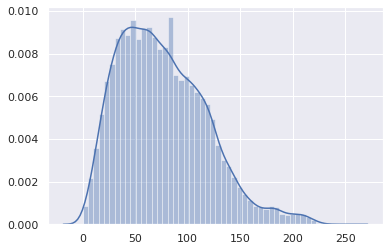

In [181]:
mas_counts = list(df_f_mas["MAS - IPSP"])
print("ACTUAL")
print(f"Size: {len(mas_counts)}")
print(f"mean: {np.mean(mas_counts)}")
print(f"std: {np.std(mas_counts)}")

sns.distplot(mas_counts);

PREDICTED
Size: 1432399.0
mean: 73.65276635129577
std: 42.21935074455513


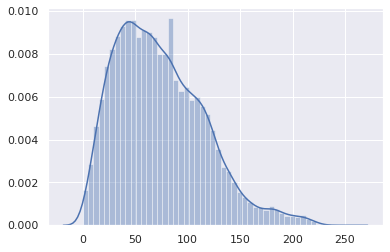

In [204]:
mas_counts = list(df_mas_f["counts"])
sume_mas = np.sum(mas_counts)
print("PREDICTED")
print(f"Size: {sume_mas}")
print(f"mean: {np.mean(mas_counts)}")
print(f"std: {np.std(mas_counts)}")

sns.distplot(mas_counts);

In [184]:
df_x.columns

Index(['País', 'Número departamento', 'Departamento', 'Provincia',
       'Número municipio', 'Municipio', 'Circunscripción', 'Localidad',
       'Recinto', 'Número Mesa', 'Código Mesa', 'Elección', 'Inscritos', 'CC',
       'FPV', 'MTS', 'UCS', 'MAS - IPSP', '21F', 'PDC', 'MNR', 'PAN-BOL',
       'Votos Válidos', 'Blancos', 'Nulos', 'Estado acta'],
      dtype='object')

In [209]:
total_votes = df_x["Votos Válidos"].sum()
print(total_votes)

6137778


In [206]:
print("MAS: ", sume_mas)
print("CC: ", sume_cc)

1432399.0
1327081.0


In [212]:
diff = sume_mas-sume_cc
print(diff)

105318.0


In [211]:
diff/total_votes*100

1.715897837947218